# Introduction
In this tutorial we are going to handle speaker recognition by applying speech recognition technique which is the ability of a machine to identify words and phrases in spoken language and conver them to machine readable. Speech recognition powers most apps today which include Google Assistant, Alexa and Siri.


# Table of Contents
- Methodology 
- Dataset Description
- Data preparation and processing
- Model Creation and Training
- Model Conversion

# Methodology
Before I learned on how to apply deep learning techniques on audio data, it always sounded weird to me how this happens. To get you upto speed we will be dealing with signal data in form of a waveform which is a graphical representation of a signal as a plot of amplitude versus time. For our case we will convert a raw signal waveform into a spectrogram giving us an image which we can apply a convolutional neural net hence convering our problem into a computer vision. A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.

We will combine the dataset with background noise since in real life there is always noise and training the model with pure noise free data while lead to inaccurate model results once deployed to use, example will be like audience claps.

Processing and modelling will be handled using TensorFlow and Spela, Spela - spectrogram layers is a package built by extending Keras layers, it aids on easy conversion of raw signal to spectrogram and can also be bundled together on a model.

# Dataset Description
The dataset we will be using is speech from five prominent leaders namely Benjamin Netanyahu, Jens Stoltenberg, Julia Gillard, Margaret Tacher and Nelson Mandela. Each recording is a 30 minute long audio 1b bit PCM encoded but has been broken down in chunks of 1 second. I have uploaded the dataset to Kaggle.

# Data preparation and processing
Data preparation is a very crucial part in creating machine learning models, processing data in to correct format will aid it producing great results, a format that the computer best understands. We will read our data using TensorFlow audio packages and prepare it with TensorFlow data. 

The most important part here is creating the data while adding background data. 

In [1]:
# Handle imports
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt # plotting functionalities
import pandas as pd
import seaborn as sns
import numpy as np # mathematical 
import tensorflow as tf # model building and training
import spela as sp # creating spectrogram layers

import librosa.display
# to handle os files
import os

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
sns.set()

In [2]:
from time_stacked import speech_model

In [3]:
# DATA directory
DATADIR = "/mnt/Data/DataScience/Dev2prodProjects/DATASETS/SpeakerData/Split/"

# DATADIR = "/mnt/Data/DataScience/DATASETS/Sound/Commands/split/"

Get the number of contents in each folder

We will use TensorFlow Dataset to build our data pipeline. In the pipeline we
will read the wav data from directory, prepare class labels, mix in background
data as mentioned above. To avoid background data overshadowing foreground real data, we can
either multiply the foreground data with a factor to increase the volume or on
background data to decrease the volume. Selection of portion of background data to mix in is selected
randomly and not that mixing happens only on the training set.

In [4]:
# prepare data classes
classes = ["_Audience_Applause_" ,"Jens_Stoltenberg", "Margaret_Thatcher",
            "Benjamin_Netanyahu", "Julia_Gillard"]

# classes = ["go", "stop", "down", "no", "off"]

# # prepare background data
# background_volume=0.5
# background_path = DATADIR+"Audience-Claps.wav"
# background_data = tf.audio.decode_wav(
#     tf.io.read_file(background_path),
#     desired_channels=1).audio

# def select_background_data():
#     background_offset = np.random.randint(0, len(background_data) - 16000)
#     background_clipped = background_data[background_offset:(background_offset+16000)]
#     return tf.multiply(background_volume,background_clipped)

In [5]:
def tf_roll(a, shift, a_len=32000):
  def roll_left(a, shift, a_len):
    shift %= a_len
    rolled = tf.concat([a[a_len - shift:, :], a[:a_len - shift, :]], axis=0)
    return rolled

  def roll_right(a, shift, a_len):
    shift = -shift
    shift %= a_len
    rolled = tf.concat([a[shift:, :], a[:shift, :]], axis=0)
    return rolled
  return tf.cond(
      tf.greater_equal(shift, 0),
      true_fn=lambda: roll_left(a, shift, a_len),
      false_fn=lambda: roll_right(a, shift, a_len))

In [6]:
# get label by splitting path
def get_label(path):
    path = tf.strings.split(path, os.path.sep)
    return path[-2] == classes

# load raw audio
def load_wav_train(path):
    wav_path = tf.io.read_file(path)
    wav_data = tf.audio.decode_wav(wav_path, desired_samples=32000, desired_channels=1)
    # mix in background data
#     background_select = select_background_data()
#     mix = tf.add(background_select, wav_data.audio)
    mix = wav_data.audio
    time_shift_range = [-500, 0]
    if np.random.uniform(0.0, 1.0) < 0.3:
        time_shift = np.random.randint(time_shift_range[0],
        time_shift_range[1] + 1)
    else:
        time_shift = 0
    mix = tf_roll(mix, time_shift, a_len=32000)
    return tf.reshape(mix, (1,32000))

def load_wav_val(path):
    wav_path = tf.io.read_file(path)
    wav_data = tf.audio.decode_wav(wav_path, desired_samples=32000, desired_channels=1)
    return tf.reshape(wav_data.audio, (1,32000))

# process the path
def process_path_train(path):
    label = get_label(path)
    wav_data = load_wav_train(path)
    return wav_data, label

def process_path_val(path):
    label = get_label(path)
    wav_data = load_wav_val(path)
    return wav_data, label

In [17]:
# get data paths with tf.data.Dataset and map the processing function
path_lists_train = tf.data.Dataset.list_files(DATADIR + "train/" + "*/*")
labeled_data_train = path_lists_train.map(process_path_train)

path_lists_val = tf.data.Dataset.list_files(DATADIR + "val/" + "*/*")
labeled_data_val = path_lists_val.map(process_path_val)
# batch the dataset and shuffle
batched_ds_train = labeled_data_train.cache().shuffle(300).batch(32)
batched_ds_val = labeled_data_val.cache().batch(32)
# check if we have prepared our dataset well
for i, j in labeled_data_train:
    print(i)
    print(j)
    break

tf.Tensor(
[[ 0.0090332   0.00238037 -0.01177979 ... -0.04492188  0.02084351
   0.06057739]], shape=(1, 32000), dtype=float32)
tf.Tensor([False False False  True False], shape=(5,), dtype=bool)


# Model Creation and Training
We have come a long way through preparing our dataset and formatting it for training and now we are going
to build and train the model. As mentioned in the methodology section, the model will consist of a spectrogram
feature extractor which will convert the raw waveform.

In [8]:
model = speech_model(input_size=32000, num_classes=len(classes))

In [18]:
# create a spectrogram feature layer
def spectrogram_layer():
    model = tf.keras.Sequential()
    model.add(sp.spectrogram.Spectrogram(
        n_dft=128, n_hop=64, input_shape=(1, 32000),
        return_decibel_spectrogram=True, power_spectrogram=2.0,
        trainable_kernel=False))
    return model


 lets use the above layer to visualize the spectrogram image it extracts

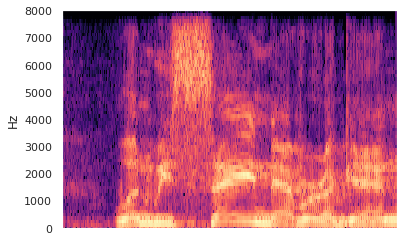

In [19]:
spec_model = spectrogram_layer()
wav = i.numpy()[np.newaxis, :]
pred = spec_model.predict(x=wav)
if tf.keras.backend.image_data_format() == "channel_first":
    result = pred[0, 0]
else:
    result = pred[0, :, :, 0]
# plot the spectrogram image
librosa.display.specshow(result, y_axis='linear', sr=16000)
plt.show()

Wow, that's so cool. We can finally generate and image which we can apply computer vision.
Next let's build a simple convolution neural network while stacking the spectrogram model on top.

In [20]:
def cnn_model():
    spec_model = spectrogram_layer()
    spec_model.add(tf.keras.layers.Conv2D(64, (3,3), activation="relu"))
    spec_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    spec_model.add(tf.keras.layers.Flatten())
    spec_model.add(tf.keras.layers.Dense(len(classes), activation="softmax"))

    # compile the model with adam optimizer and cross entropy loss
    spec_model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=3e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return spec_model

model = cnn_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectrogram_4 (Spectrogram)  (None, 65, 500, 1)        16640     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 498, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 249, 64)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 494016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2470085   
Total params: 2,487,365
Trainable params: 2,487,365
Non-trainable params: 0
_________________________________________________________________


We have successfully created our model it's now time to train it and see
how it performs, we don't know for sure how it will but am passionate that
will do great.

In [21]:
epochs = 5
model.fit(batched_ds_train, validation_data=batched_ds_val, epochs=epochs)

Epoch 1/5
101/101 [==============================] - 14s 135ms/step - loss: 98.9193 - accuracy: 0.5617 - val_loss: 5.6940 - val_accuracy: 0.8362
Epoch 2/5
101/101 [==============================] - 10s 98ms/step - loss: 3.1749 - accuracy: 0.9013 - val_loss: 3.7610 - val_accuracy: 0.8421
Epoch 3/5
101/101 [==============================] - 10s 98ms/step - loss: 1.2053 - accuracy: 0.9406 - val_loss: 1.1925 - val_accuracy: 0.9534
Epoch 4/5
101/101 [==============================] - 10s 98ms/step - loss: 1.1024 - accuracy: 0.9331 - val_loss: 3.8746 - val_accuracy: 0.8326
Epoch 5/5
101/101 [==============================] - 10s 98ms/step - loss: 0.8016 - accuracy: 0.9609 - val_loss: 1.0519 - val_accuracy: 0.9643


In [37]:
model.save_weights("model_weights.h5")

wow the model performs so well, this dataset is close to clean and the results are satisfying. You can see that
extracted spectrogram form a waveform is a great feature to distinguish speaker or audios.

Let's compute and plot confusion matrix using validation set


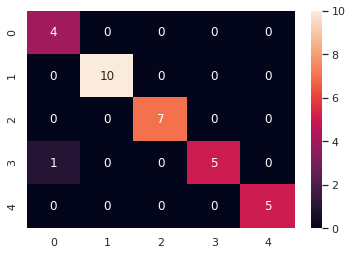

In [22]:
# get the data
val_x, val_y= next(iter(batched_ds_val))

# get true labels
true_labels = np.array([np.where(i == True)[0][0] for i in val_y])

# make predictions
predicted_labels = np.argmax(model.predict(val_x), axis=-1)

# cmpute a confusion matrix
cm = confusion_matrix(true_labels,predicted_labels)
# plot the confusion matrix
sns.heatmap(pd.DataFrame(cm), annot=True)

We can see that the model predicts correctly for all the classes and are confident that it will perform well in production.

# Model Conversion and Saving
Having prepared the data and trained the model, we are now ready to convert the model to TensorFlow lite and save for use in production, this process is quite straight forward. Wecwill also save labels according to their order.

In [23]:
# get model
conveter = tf.lite.TFLiteConverter.from_keras_model(model)
# convert the model
tflite_model = conveter.convert()
# save model to directory
open("assets/tflite_model.tflite", "wb").write(tflite_model)

# write labels to disk
with open("assets/labels.txt", "w") as l:
    for i in classes:
        l.write(i)
        l.write("\n")
    l.close()

# Conclusion
Congratulations for reaching the end of this tutuorial, I know we have convered alot. The techniques we have applied are very effective, more backgrouund data could be added according to the settngs of where the model will be deployed. For our case we used audience claps which is common when one is making a speech.Apart from the spectrogram applied for this tutorial, there is melspectrogram which is simply a spectrogram where frequencies are converted to mel scale. Mel scale are lower frequencies range where human hear best detect differences in sound.

You can jump straight to the production tutorial and learn how to deploy this mmodel to mobile device.

# References
1. Roberts, L. (2020, March 14). Understanding the Mel Spectrogram. Retrieved June 25, 2020, from https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

2. Practicalcryptography.com. 2020. Practical Cryptography. [online] Available at: <http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/> [Accessed 25 June 2020].